# Construct Dataset

In [43]:
import pycbc.noise
import pycbc.psd
import pycbc.filter
import pylab
from pycbc.filter import sigma
from pycbc.waveform import get_td_waveform
from pycbc.types.timeseries import load_timeseries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.random import uniform, randint
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split

#import from other notebooks functions for data generation
import sys
sys.path.insert(0, '../functions')
from ipynb.fs.defs.false_signals import random_false_sig, flip_gw
from ipynb.fs.defs.generate_data import noise, burried_gw, partial_burried_false, partial_burried_gw, burried_false, burried_flip, visualize, bol, empty_gaussian

Trial 1A information:
- SNR 1000
- signals fully contained in windows of 1 second
- masses randomly generated (ranges for masses shown below)
- train and test generated in one batch. Then separate.

The following range guarentees that the whole waveform < around 0.8 so that it fits in the window.)

SCHEME:
- 75-100 and 10-100
- 70-75 and 12-75
- 65-70 and 14-70
- 55-65 and 16-65 
- 50-55 and 18-55
- 45-50 and 20-50
- 40-45 and 24-45
- 35-40 and 28-40
- 30-35 and 30-35

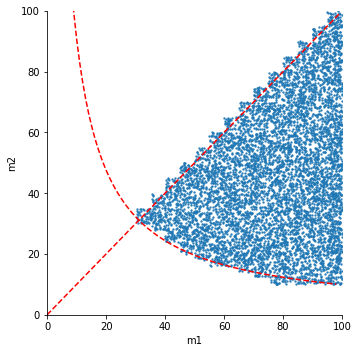

In [44]:
# Randomly generate masses 
# Training masses 
mass = []
for i in np.arange(2):   # repeat process twice for data
    for u in np.arange(95,101):
        for l in np.arange(10,101):
            mass.append([uniform(95,100),uniform(10,100)])
    for u in np.arange(90,95):
        for l in np.arange(10,95):
            mass.append([uniform(90,95),uniform(10,95)])
    for u in np.arange(85,90):
        for l in np.arange(10,90):
            mass.append([uniform(85,90),uniform(10,90)])
    for u in np.arange(80,85):
        for l in np.arange(10,85):
            mass.append([uniform(80,85),uniform(10,85)])
    for u in np.arange(75,80):
        for l in np.arange(10,80):
            mass.append([uniform(75,80),uniform(10,80)])
    for u in np.arange(70,75):
        for l in np.arange(12,75):
            mass.append([uniform(70,75),uniform(12,75)])
    for u in np.arange(65,70):
        for l in np.arange(14,70):
            mass.append([uniform(65,70),uniform(14,70)])
    for u in np.arange(60,65):
        for l in np.arange(16,65):
            mass.append([uniform(60,65),uniform(16,65)])
    for u in np.arange(55,60):
        for l in np.arange(16,60):
            mass.append([uniform(55,60),uniform(16,60)])
    for u in np.arange(50,55):
        for l in np.arange(18,55):
            mass.append([uniform(50,55),uniform(18,55)])
    for u in np.arange(45,50):
        for l in np.arange(20,50):
            mass.append([uniform(45,50),uniform(20,50)])
    for u in np.arange(40,45):
        for l in np.arange(24,45):
            mass.append([uniform(40,45),uniform(24,45)])
    for u in np.arange(35,40):
        for l in np.arange(28,40):
            mass.append([uniform(35,40),uniform(28,40)])
    for u in np.arange(30,35):
        for l in np.arange(30,35):
            mass.append([uniform(30,35),uniform(30,35)])

mass = pd.DataFrame(mass)
mass.columns = ['m1','m2']

# Create scatterplot of dataframe
sns.lmplot('m1', 'm2', data=mass, fit_reg=False, 
           scatter_kws={"s": 2})
plt.ylim(0,100)
plt.xlim(0,100)

plt.plot(np.arange(100),'r--')
plt.plot(1000/np.arange(1,100),'r--')
plt.show()

In [45]:
# constants and variables
snr = 1000
mag = -21   # for false signals. Try to be close to the amplitude of gw signals
select = bol(3,len(mass))

In [46]:
# data!
X = []
y = []

# extra data for regression trials
reg_X = []
reg_y = mass

# Generate true cases that contain gw, classification label 1.

for i in tqdm(range(len(mass))):
    gww = burried_gw(mass.loc[i,'m1'], mass.loc[i,'m2'], snr)
    reg_X.append(np.asarray(gww))
    X.append(np.asarray(gww))
    y.append(1)
    
    # Insert false flipped case as well as empty gaussian after every 3 true cases
    if select[i]:
        wf = burried_flip(mass.loc[i,'m1'], mass.loc[i,'m2'], snr)
        X.append(np.asarray(wf))
        y.append(0)
        
        wf = noise(gww,snr)
        X.append(np.asarray(wf))
        y.append(0)
        
# Generate more data with empty gaussian on varying magitudes
for i in tqdm(range(1226)):
    wf = empty_gaussian(uniform(0,30))
    X.append(np.asarray(wf))
    y.append(0)
    
    wf = empty_gaussian(1.0/uniform(0,30))
    X.append(np.asarray(wf))
    y.append(0)


100%|██████████| 1226/1226 [02:53<00:00,  7.26it/s]


In [47]:
# Save as dataframe
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y)
reg_X_df = pd.DataFrame(reg_X)

In [48]:
# Since sklearn makes things a lot easier, can just store the whole data and split every time. 
# If want to recreate the split just use same random seed
# write data into the same file under different keys

# '''ALREADY DONE NO NEED REPEAT
f_path = 'c_data_1A.h5'
X_df.to_hdf(f_path, key='X', mode='w')
y_df.to_hdf(f_path, key='y')
reg_X_df.to_hdf(f_path, key='reg_X')
reg_y.to_hdf(f_path, key='reg_y')
#'''

# Data Statistics

In [49]:
# statistic information
print("Number of data: ",len(X))

pos = 0
for i in np.arange(len(X)):
    pos += y[i]

print("Percentage ",100* pos/len(X), "% of data contains gw wave.")

Number of data:  14722
Percentage  50.006792555359326 % of data contains gw wave.
